# Logistic Regression with Python
To predict a classification- survival or deceased

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib auto

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
train = pd.read_csv('titanic_train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis
## Missing Data
Using seaborn to create a simple heatmap to see where we are missing data!

In [5]:
train.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


<Axes: >

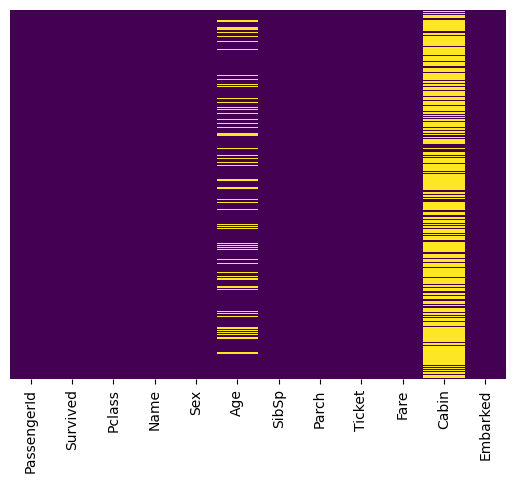

In [6]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

<Axes: xlabel='Survived', ylabel='count'>

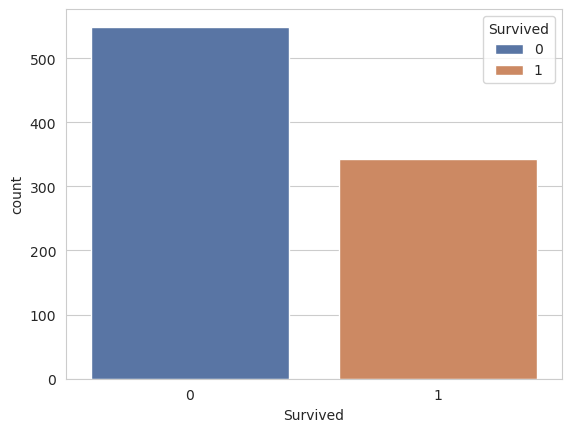

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train, hue='Survived', palette='deep')

<Axes: xlabel='Survived', ylabel='count'>

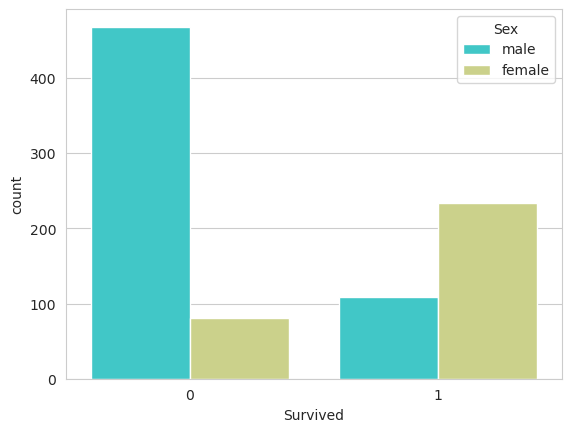

In [8]:
sns.countplot(x='Survived',data=train, hue='Sex', palette='rainbow')

<Axes: xlabel='Survived', ylabel='count'>

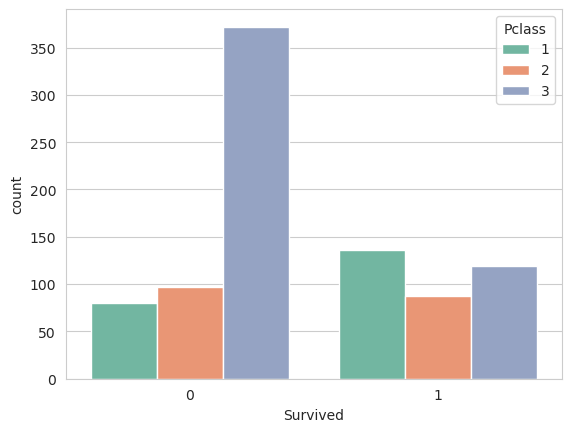

In [9]:
sns.countplot(x='Survived', data=train, hue='Pclass', palette="Set2")

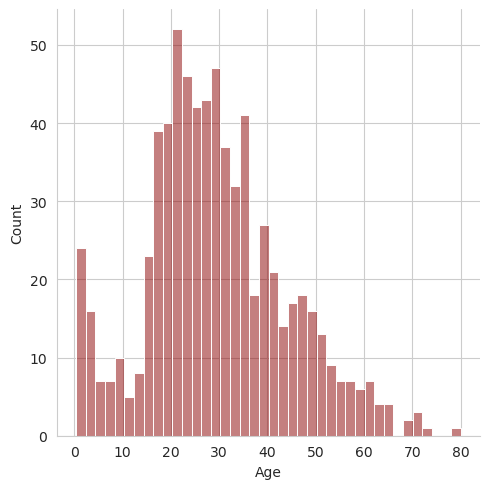

In [10]:
sns.displot(train['Age'].dropna(), color='darkred', bins=40, alpha=0.5) # using displot of seaborn

<Axes: >

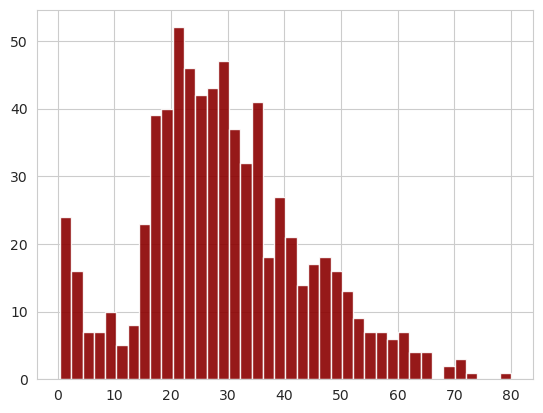

In [11]:
train['Age'].hist(bins=40,color='darkred',alpha=0.9) #using matplotlib

<Axes: xlabel='SibSp', ylabel='count'>

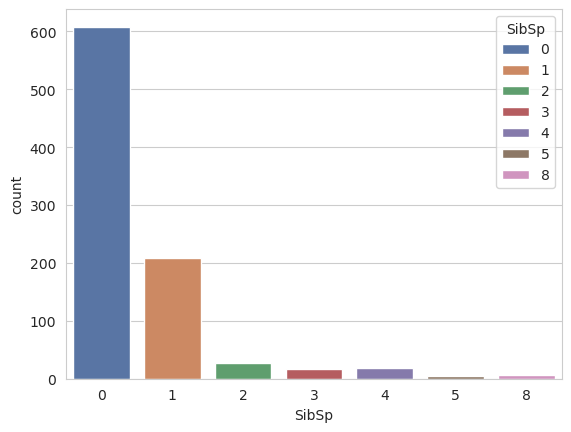

In [12]:
sns.countplot(x='SibSp', data=train, hue='SibSp', palette='deep')

<Axes: >

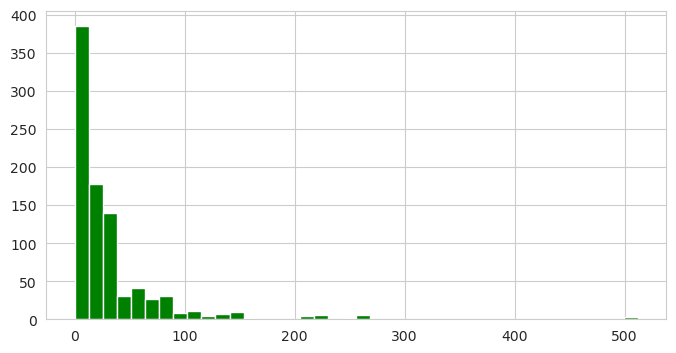

In [13]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

# Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation). However we can be smarter about this and check the average age by passenger class. For example:

<Axes: xlabel='Pclass', ylabel='Age'>

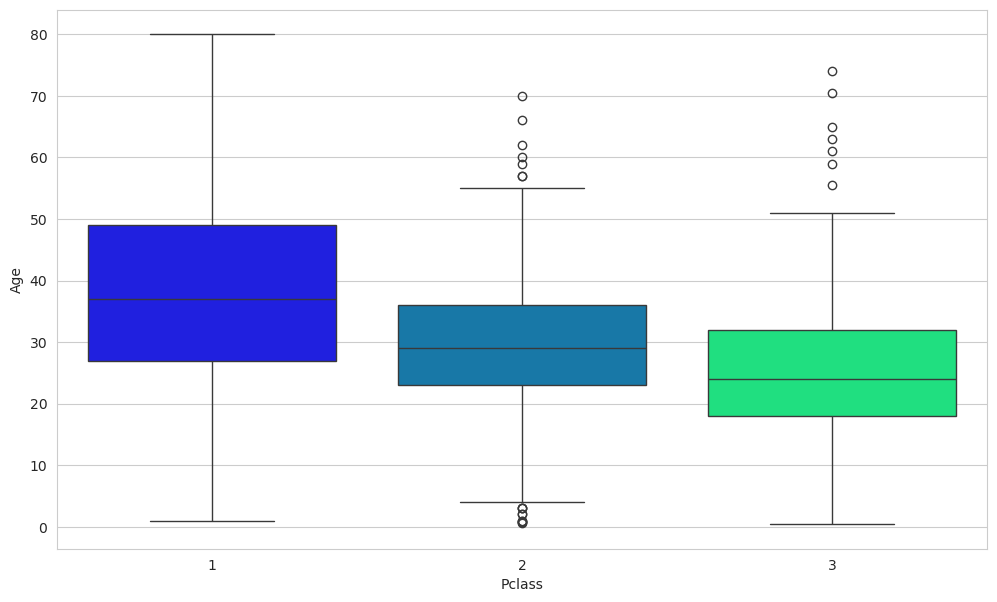

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass', y='Age', data=train, hue="Pclass", legend=False, palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [15]:
def impute_age(cols):
    Age=cols['Age']
    Pclass=cols.iloc[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [16]:
train['Age'] = train[['Pclass', 'Age']].apply(impute_age, axis=1)

<Axes: >

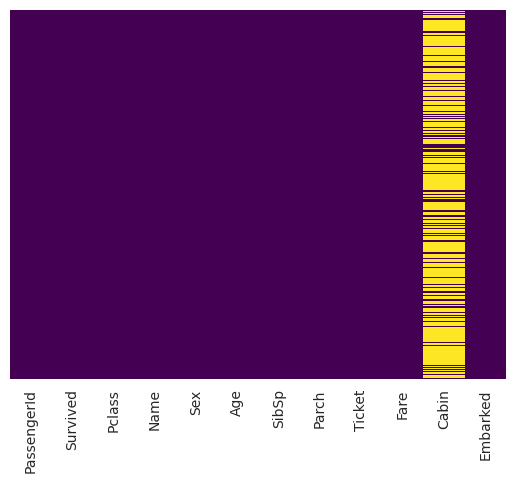

In [17]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Now dropping the Cabin column and the row in Embarked that is NaN.

In [18]:
train.drop('Cabin', axis='columns', inplace=True) #can also write axis=1

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S



# Converting Categorical Features

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [21]:
pd.get_dummies(train['Embarked'],drop_first=True, dtype=int).head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [22]:
sex = pd.get_dummies(train['Sex'],drop_first=True, dtype=int)
embark = pd.get_dummies(train['Embarked'],drop_first=True, dtype=int)

In [23]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [24]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [25]:
pd.concat([train, sex, embark], axis=1).head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [26]:
train.drop('Survived', axis=1).head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [27]:
train['Survived'].head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
logmodel = LogisticRegression(max_iter=500)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=500)

In [32]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [33]:
predictions = logmodel.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
accuracy=confusion_matrix(y_test,predictions)
accuracy

array([[136,  18],
       [ 63,  51]])

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy=accuracy_score(y_test,predictions)
accuracy

0.6977611940298507

In [38]:
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0])

# Evaluation

In [39]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       154
           1       0.74      0.45      0.56       114

    accuracy                           0.70       268
   macro avg       0.71      0.67      0.66       268
weighted avg       0.71      0.70      0.68       268



To explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:
---
Todos:
---
    1. Grab the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
    2. Maybe the Cabin letter could be a feature
    3. Is there any info you can get from the ticket?
